## Introduction

In this notebook, we're going to see how to build a circuit in qiskit and then run it on both a simulator and a real device.

The first thing we need to do is import qiskit and make sure its working.

In [1]:
from qiskit import QuantumCircuit

If that runs without errors, then everything's good!

Next we'll create a QuantumCircuit object. When doing so, we have to specify how many qubits the circuit should have. 

We'll begin with a single qubit circuit and we'll call the object 'qc' for short

In [2]:
qc = QuantumCircuit(1) # creates a QuantumCircuit object with 1 object

### Experiment 1 - measuring a superposition

The first thing we'll do is prepare and measure a plus state (just because we can ;) )

To do that, we need to apply a Hadamard gate to our circuit and then measure it. In qiskit, we can apply a Hadamard gate with the $h(i)$ function where $i$ is which qubit we're applying the gate on. (NB: **indexing starts at 0**) 

In [4]:
qc.h(0) #applies H gate to first (and only) qubit

qc.measure_all() # measures all (only) qubits

To see what our circuit looks like, we can do .draw() or .draw(output='mpl') to make it look nicer

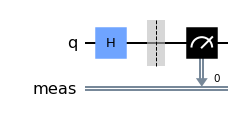

In [6]:
#qc.draw()
qc.draw(output='mpl')

Looks good!

Now, we need to set up some things so that we can run our circuit. First, we'll use a simulator called qasm_simulator which we can load in from a qiskit module called Aer

In [7]:
from qiskit import Aer, execute #import stuff

backend = Aer.get_backend("qasm_simulator") # Tell Aer which simulator we want

job = execute(qc, backend, shots=1024) #run the circuit qc on the specified backend 1024 times
print(job.status())

JobStatus.DONE


Then we can check our results:

In [8]:
results = job.result().get_counts()
print(results)

{'1': 509, '0': 515}


Notice that the numbers aren't identical, because of random fluctuations. To see the rough proportions we can plot a histogram of these results

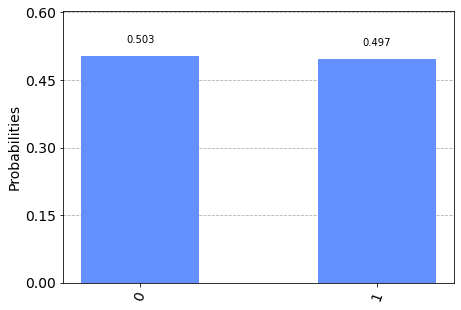

In [9]:
from qiskit.visualization import plot_histogram
plot_histogram(results)

Cool! Now let's run it on a **real** quantum computer. The first step for that is to link your computer with your IBM account. Go to https://quantum-computing.ibm.com/, login and find where it says API token. Then copy the token to your clipboard, uncomment the line and paste it in

In [10]:
from qiskit import IBMQ

#IBMQ.save_account("INSERT TOKEN HERE") #remove the first '#' to run this line with your token. You only need to do this once in your life

provider = IBMQ.load_account() #gets your details from IBM
print(provider.backends()) #gets a list of devices you're allowed to use

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBM

Now we just choose one of these as our backend and execute as we did before

In [11]:
backend = provider.get_backend("ibmq_lima")

job = execute(qc, backend, shots=1024) #run the circuit qc on the specified backend 1024 times

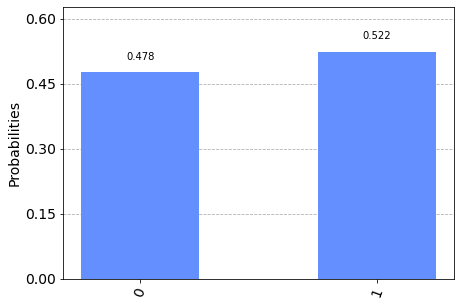

In [12]:
results = job.result().get_counts()
plot_histogram(results)

### Experiment 2 - interference

Consider the following circuit

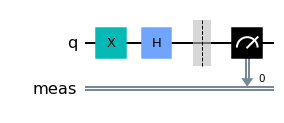

In [16]:
qc2 = QuantumCircuit(1)
qc2.x(0)
qc2.h(0)
qc2.measure_all()
qc2.draw(output='mpl')

- What do you expect when you measure it?
- What state does it produce?
- How is qc2 different to qc? How might we distinguish them?

We now know how to answer the first question, so lets see! We'll go back to the simulator since its a bit quicker

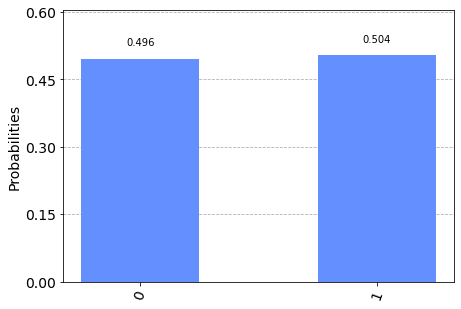

In [17]:
backend = Aer.get_backend("qasm_simulator")
result = execute(qc2, backend, shots=1024).result()
plot_histogram(result.get_counts())

Looks a bit familiar...

Let's investigate the differences more closely.


First, we'll create a new circuit with 2 qubits, one in the |+> state and one in the |-> state.

Recall $\newcommand{\ket}[1]{|#1\rangle} \ket{+} = \frac{\ket{0} + \ket{1}}{\sqrt{2}}, \ket{-} = \frac{\ket{0} - \ket{1}}{\sqrt{2}}$

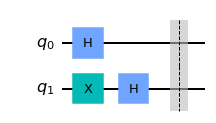

In [18]:
qc3 = QuantumCircuit(2) # make a circuit with 2 qubits

qc3.h(0) # prepare |+> state in first qubit

qc3.x(1)
qc3.h(1) # prepare |-> state in second qubit

qc3.barrier() #inserts a barrier in our circuit for convenience

qc3.draw(output='mpl')

Then, we can use interference to 'cancel out' the superpositions:

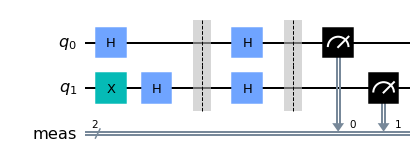

In [19]:
qc3.h(0)
qc3.h(1)

qc3.measure_all()

qc3.draw(output='mpl')

And see what happens:

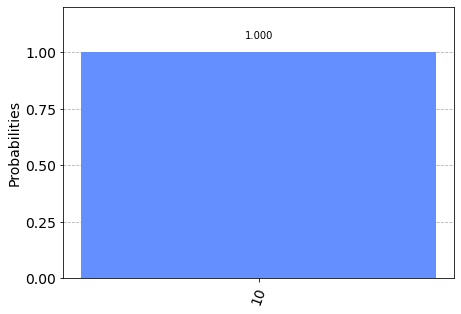

In [20]:
result = execute(qc3, backend, shots=1024).result()
plot_histogram(result.get_counts())

We measure '10' deterministically. This means that the bottom qubit is 1 every time and the top qubit is 0 every time. It also means there is a difference between |+> and |->, since we can distinguish them with an H gate!

Finally, let's just make sure we get the same results with a real device. 

running...
done


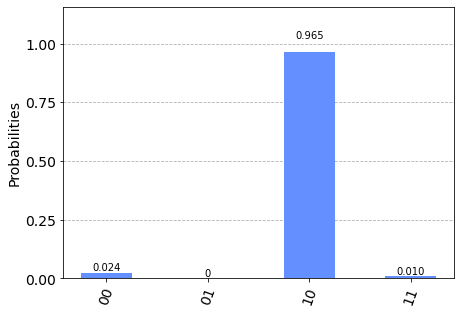

In [21]:
backend = provider.get_backend("ibmq_lima")
print("running...")
result = execute(qc3, backend, shots=1024).result()
print("done")
plot_histogram(result.get_counts())

We get '10' almost all the time, but not quite. This is because real quantum computers still aren't perfect and they can cause errors. So occasionally, we don't get the results we should. 

Let's check this works analytically too:


$$ H \ket{+} = H \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) = \frac{1}{\sqrt{2}}(H\ket{0} + H\ket{1}) = \frac{1}{2}(\ket{0} + \ket{1} + \ket{0} - \ket{1}) = \frac{1}{2} (2\ket{0}) = \ket{0}$$

$$ H \ket{-} = H \frac{1}{\sqrt{2}}(\ket{0} - \ket{1}) = \frac{1}{\sqrt{2}}(H\ket{0} - H\ket{1}) = \frac{1}{2}(\ket{0} + \ket{1} - \ket{0} + \ket{1}) = \frac{1}{2} (2\ket{1}) = \ket{1}$$